In [1]:
from project.utils.transforms import DVSTransform
from project.datamodules.fer_dvs import FerDVS

# Configuration des transformations
transforms_list = ["flip", "background_activity", "crop", "reverse", "mirror", "event_drop"]
transform = DVSTransform(
    sensor_size=FerDVS.sensor_size,  
    timesteps=6,  # Le nombre de pas de temps 
    transforms_list=transforms_list,
    concat_time_channels="snn"  
)


In [2]:
from project.fer_module import FerModule

model = FerModule(
    learning_rate=0.005,  
    timesteps=6,
    n_classes=6,  
    epochs=1000,  
    mode="snn"
)


checkpoint_path = "C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\experiments\\CKPlusDVS_0\\version_31\\checkpoints\\0_epoch=717_val_acc=0.7324.ckpt"
model.load_from_checkpoint(checkpoint_path)
model.eval()


FerModule(
  (model): SNNModule(
    (encoder): MultiStepSEWResNet(
      (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sn1): MultiStepIFNode(
        v_threshold=1.0, v_reset=0.0, detach_reset=True, backend=torch
        (surrogate_function): ATan(alpha=2.0, spiking=True)
      )
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): MultiStepBasicBlock(
          cnf=ADD
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (sn1): MultiStepIFNode(
            v_threshold=1.0, v_reset=0.0, detach_reset=True, backend=torch
            (surrogate_function): ATan(alpha=2.0, spiking=True)
          )
          (conv2): Conv2d(6

In [3]:
import h5py
import numpy as np
from project.utils.drop_event import drop_by_area_numpy
sensor_size=FerDVS.sensor_size
# Chargement d'un exemple de données depuis un fichier h5
data_path = "C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\data\\FerDVS\\CKPlusDVS\\S010\\005.h5"
with h5py.File(data_path, 'r') as f:
    events = np.array(f['events'])


dtype = np.dtype([("x", np.int16), ("y", np.int16), ("p", bool), ("t", np.int64)])
structured_events = np.array([tuple(e) for e in events], dtype=dtype)

valid_events = structured_events[
    (structured_events['x'] >= 0) & 
    (structured_events['x'] < sensor_size[0]) & 
    (structured_events['y'] >= 0) & 
    (structured_events['y'] < sensor_size[1])
]
events_transformed = transform(valid_events)


In [4]:
print(valid_events)

[(42, 84,  True, 0)]


In [5]:
import torch


if len(events_transformed.shape) == 4:  # Si la forme est (C, H, W) ou (T, C, H, W)
    events_transformed = events_transformed.unsqueeze(0)  # Ajoute une dimension de batch
if len(events_transformed.shape) == 3:  # Si la forme est (C, H, W)
    events_transformed = events_transformed.unsqueeze(0)  # Ajoute une dimension de temps
events_transformed = events_transformed.unsqueeze(0)
# Convertissez en tenseur PyTorch et déplacez sur le bon dispositif
events_transformed_tensor = events_transformed.clone().detach().to(model.device)



if events_transformed_tensor.size(2) == 12:
    events_transformed_tensor = events_transformed_tensor.mean(dim=1, keepdim=True)


if events_transformed_tensor.size(1) != 2:
    events_transformed_tensor = events_transformed_tensor[:, :2, :, :, :]


events_transformed_tensor = events_transformed_tensor.permute(2, 0, 1, 3, 4)

print("Nouvelle forme du tenseur:", events_transformed_tensor.shape)


events_transformed_tensor = events_transformed_tensor.permute(0, 1, 2, 3, 4)


if events_transformed_tensor.size(2) == 1:
    events_transformed_tensor = torch.cat([events_transformed_tensor, events_transformed_tensor], dim=2)

print("Forme ajustée du tenseur:", events_transformed_tensor.shape)



Nouvelle forme du tenseur: torch.Size([12, 1, 1, 128, 128])
Forme ajustée du tenseur: torch.Size([12, 1, 2, 128, 128])


In [6]:
# Faire une prédiction
with torch.no_grad():
    prediction = model(events_transformed_tensor)

In [14]:
Y=events_transformed_tensor
print(Y)

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,

In [15]:
import numpy as np
X = np.load('X.npy')  # Chargement de X à partir du fichier
X=torch.from_numpy(X)
print(X)

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  

In [16]:
torch.eq(X, Y)

RuntimeError: The size of tensor a (32) must match the size of tensor b (12) at non-singleton dimension 0

In [7]:
print("Prédiction:", prediction)

Prédiction: tensor([[-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166],
        [-0.0016, -0.0171, -0.0227, -0.0132, -0.0068, -0.0166]])


Classe prédite:
 anger


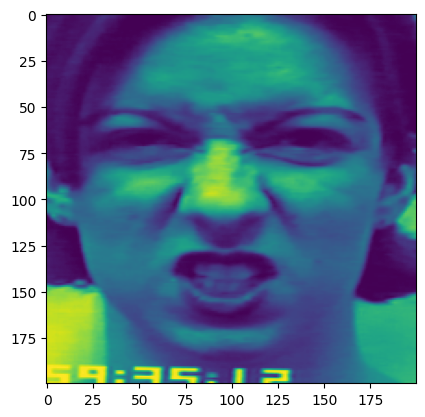

In [9]:
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image


classes = [
        "happy",
        "fear",
        "surprise",
        "anger",
        "disgust",
        "sadness",
    ]
# Appliquer Softmax pour obtenir des probabilités
probabilities = torch.softmax(prediction, dim=1)

# Obtenir les classes prédites
predicted_classes = torch.argmax(probabilities, dim=1)
predicted_classe = predicted_classes[0].item()
# Afficher l'image correspondant à la classe prédite
img_path = "C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\data\\FerDVS\\CKPlusDVS\\S010\\005\\img_013.png"
img = mpimg.imread(img_path)
plt.imshow(img)
print("Classe prédite:\n", classes[predicted_classe])



